In [ ]:
# To Do
# 

In [115]:
Author = 'Conrad'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import datetime
import time
import pytz
local_timezone = 'America/Los_Angeles'
from time import gmtime, strftime

from scipy import stats
import numpy as np
import pandas as pd
#from pandas.plotting import scatter_matrix
import xarray as xr
from pandas import Series
import seaborn as sns
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 8.0)

import yfinance as yf

from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import maxabs_scale
from sklearn.preprocessing import Binarizer as binarizer

from sklearn.decomposition import FastICA, PCA
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression
from sklearn import cluster
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import mixture
                                  
from sklearn.metrics import mean_squared_error as rmse 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import explained_variance_score as evs
from sklearn.metrics import r2_score as r_squared
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV


#kbest = SelectKBest(chi2, k=20)

                                  
        

In [164]:
# SET KEYLINE TIME RELATED PARAMETERS
IS = slice("2011-08-26", "2016-08-05")
OOS = slice("2016-08-06", "2023-11-30")
ALL = slice("2011-08-26","2023-11-30")
cal = {}
cal['z_score_window'] = 252
cal['regression_est_window'] = 400
cal['sim_time'] = time.strftime('%x %X')
cal['OOS'] = slice("2016-08-06", "2023-11-30")
cal['IS'] = slice("2000-08-06", "2016-08-05")
cal['ALL'] = slice("2000-08-06", "2016-08-05")

print(cal['sim_time'])
print('In-Sample',IS)
print('Out-of-Sample',OOS)
print('All-Dates',ALL)


12/01/23 17:37:25
In-Sample slice('2011-08-26', '2016-08-05', None)
Out-of-Sample slice('2016-08-06', '2023-11-30', None)
All-Dates slice('2011-08-26', '2023-11-30', None)


In [33]:
# FUNCTION FOR TIME-SAFE Z-SCORES
def z_score(df,window = cal['z_score_window']):
    window = cal['z_score_window']
    rstd = df.rolling(window=window,min_periods=window).std()
    #print('std',rstd)
    rmean = df.rolling(window=window,min_periods=window).mean()
    #print('mean',rmean)
    z = (df - rmean) / rstd
    #print('z',z)
    z = z.dropna()
    #print('zdropna',z)
    return z

In [4]:
# FUNCTIONS FOR Re-Basing Returns & computing log returns from a price levels

def rebase_rets(input):
    output = pd.DataFrame(input).set_index(pd.DatetimeIndex(input.index))
    output = output.dropna()
    output = 1+output.cumsum()
    return output

def log_returns(df):
    df = np.log(df)
    df = df - df.shift(1)
    #df.index.name = None
    return df

def pct_returns(df):
    df = df.pct_change()
    return df

def generate_train_predict_calender(df, window_size):
    date_ranges = []
    index = df.index
    num_days = len(index)

    for i in range(0, num_days - window_size):
        #if i + window_size <= len(index):
        train_start_date = index[i]
        train_end_date = index[i + window_size - 1]
        prediction_date = index[i + window_size]
        date_ranges.append([train_start_date, train_end_date, prediction_date])

    return date_ranges


def apply_ewm(X, halflife):
    return X.ewm(halflife=halflife).mean()

In [193]:
#  Load and preprocess the data

y_level = yf.download(['SPY'])['Adj Close'].dropna()
y_level = y_level.to_frame(name='SPY')
y = log_returns(y_level)  # process as log returns

X_level = pd.read_pickle('Hull_X_levels.pkl')
X_level = X_level.drop(['US3M','PCUSEQTR','SPXDIV'],axis=1)

X_log_returns = log_returns(X_level).shift(1)  # Lagging all features 1 day 
X = z_score(X_log_returns,252) # preprocess as z-scores

# Sync the indexes
y = y.reindex(X.index)
y = pd.DataFrame(y,columns=['SPY'])


[*********************100%%**********************]  1 of 1 completed


In [107]:
# for col in X_level.columns:
#     if X_level[col].le(0).any():
#         print(col)

# for col in X_level.columns:
#     if np.log(X_level[col]).isna().any():
#        print(X_level[col])

In [108]:
def t_func_1(df,pred_col='predicted', actual_col='actual',new_col='perf'):
    t_conditions = [ df[pred_col] >= 0, df[pred_col] < 0 ]
    t_positions =  [ df[actual_col]*1,  df[actual_col]*-1 ]
    return np.select(t_conditions,t_positions, default=np.nan) # Apply trading logic here


def t_func_2(df,pred_col='predicted', actual_col='actual',new_col='perf'):
    t_conditions = [ df[pred_col] >= 0, df[pred_col] < 0 ]
    t_positions =  [ df[actual_col]*1.8,  df[actual_col]*0 ]
    return np.select(t_conditions,t_positions, default=np.nan) # Apply trading logic here

In [109]:
all_data = slice(y.index.min(),y.index.max())

In [110]:
def sim_stats(regout_list,sweep_tags,author='CG',trange = all_data):
    df = pd.DataFrame()
    for n, testlabel in enumerate(sweep_tags):
        reg_out = regout_list[n].loc[trange,:]
        df.loc['mean',testlabel] = mean = 252*reg_out.perf_ret.mean()
        df.loc['stdev',testlabel] = std = (np.sqrt(252))*reg_out.perf_ret.std()
        df.loc['sharpe',testlabel] = mean / std
        df.loc['pos_bet_ratio',testlabel] = np.sum(np.isfinite(reg_out['predicted']) & (reg_out['predicted'] > 0)) / np.sum(np.isfinite(reg_out['predicted']))

        df.loc['rmse',testlabel] = np.sqrt(rmse(reg_out.predicted,reg_out.actual))
        df.loc['mae',testlabel] = mae(reg_out.predicted,reg_out.actual)
        df.loc['evs',testlabel] = evs(reg_out.predicted,reg_out.actual)
        df.loc['r2',testlabel] = r_squared(reg_out.predicted,reg_out.actual)
        df.loc['benchmark return',testlabel] = bench_ret = 252*reg_out.actual.mean()
        df.loc['benchmark std',testlabel] = bench_std = (np.sqrt(252))*reg_out.actual.std()
        df.loc['benchmark sharpe',testlabel] = bench_ret / bench_std
        df.loc['beg_pred',testlabel] = min(reg_out.predicted.index).date()
        df.loc['end_pred',testlabel] = max(reg_out.predicted.index).date()
        df.loc['train window',testlabel] = window=cal['regression_est_window'] 
        df.loc['z_score_window',testlabel] = cal['z_score_window']
        df.loc['sim_time',testlabel] =  datetime.now(pytz.timezone(local_timezone)).strftime("%x %-I:%-m%p") 
        df.loc['author',testlabel] = author
    return df

In [111]:
# ROLL FORWARD SIMULATOR - 1) TRAIN UP TO T-1, 2) PREDICT AT T, 3) TRADE

def Simulate(X,y,window=cal['regression_est_window'],pipe_steps={},dims_dict={}):    
    regout = pd.DataFrame(index=y.index)
    
    date_ranges = generate_train_predict_calender(X, window)
    
    pipe = Pipeline(steps=pipe_steps)
    pipe.set_params(**dims_dict)

    for n,dates in enumerate(date_ranges):

        start_training, end_training, prediction_date = dates[0], dates[1],dates[2]

        fit_X = X[start_training:end_training]
        fit_y = y[start_training:end_training]
        pred_X = X[prediction_date:prediction_date]
        
        pipe.fit(fit_X,fit_y)
        #print('pred_date',prediction_date,'features = ',pipe.named_steps['eln'].n_features_in_)
        #regout.loc[prediction_date,'expl_var'] = pipe.named_steps['pca'].explained_variance_ratio_[2]
        #regout.loc[prediction_date,'coeff_1st_dim'] = pipe.named_steps['reg'].coef_[0]
                
        regout.loc[prediction_date,'predicted'] = pipe.predict(pred_X)
    
    return regout.dropna()

In [ ]:
# Simulate Dim Reduction -> Linreg
last_printed_time = datetime.now()
regout_list = []
Results_xr = xr.Dataset()
Results_df = pd.DataFrame()

## Dim Reduction
pca = PCA()
clust = cluster.FeatureAgglomeration(n_clusters=4)
kbest = SelectKBest(chi2, k=20)

## Estimators
ols = LinearRegression()
eln = ElasticNet()
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=.5)

In [135]:
#pipe = Pipeline([('ewm', FunctionTransformer(apply_ewm, kw_args={'halflife': halflife}))])
regout_list = []
Results_xr = xr.Dataset()
Results_df = pd.DataFrame()
max_sweep_n = 5
sweep_n = [n for n in range(5,20)]
last_printed_time = datetime.now()

kbest_tags = sweep_tags = ['kbest_'+str(n)+'_reg' for n in sweep_n]

for n, test_param in enumerate(sweep_n):
    print('test',n)
    
    # pipe_steps=[('ewm', FunctionTransformer(apply_ewm, kw_args={'halflife': test_param})), 
    #             ('pca', PCA(n_components=2)),
    #             ('ols', LinearRegression(fit_intercept=True))]

    pipe_steps=[('kbest',  SelectKBest(mutual_info_regression, k=test_param)), 
                ('ols', LinearRegression(fit_intercept=True))]


    dims_dict = {} 
    
    regout_df = Simulate(X,y,window=cal['regression_est_window'],pipe_steps=pipe_steps,dims_dict=dims_dict)
    regout_df['actual'] = y[regout_df.predicted.index].dropna()
    regout_df['perf_ret'] = t_func_2(regout_df,pred_col='predicted', actual_col='actual',new_col = 'perf') # Enter Trading Func
    regout_df['perf_mtm'] = regout_df['perf_ret'].cumsum()
    regout_df['es_mtm'] = regout_df['actual'].cumsum()
    regout_list.append(regout_df)
    
    sim_xr = regout_df.to_xarray().expand_dims(Tag=[sweep_tags[n]])    
    Results_xr = xr.merge([Results_xr,sim_xr])

    

    current_time = datetime.now()
    time_elapsed = current_time - last_printed_time
    last_printed_time = current_time
    print(sweep_tags[n],'sim time = ',time_elapsed)

Results_df = sim_stats(regout_list,sweep_tags,author='CG')
   

test 0
kbest_5_reg sim time =  0:02:20.995788
test 1
kbest_6_reg sim time =  0:02:15.540896
test 2
kbest_7_reg sim time =  0:02:17.307890
test 3
kbest_8_reg sim time =  0:02:19.114396
test 4
kbest_9_reg sim time =  0:02:13.713866
test 5
kbest_10_reg sim time =  0:02:13.073848
test 6
kbest_11_reg sim time =  0:02:17.240558
test 7
kbest_12_reg sim time =  0:02:14.815950
test 8
kbest_13_reg sim time =  0:02:14.494244
test 9
kbest_14_reg sim time =  0:02:13.295834
test 10
kbest_15_reg sim time =  0:02:13.760033
test 11
kbest_16_reg sim time =  0:02:13.492045
test 12
kbest_17_reg sim time =  0:02:13.368709
test 13
kbest_18_reg sim time =  0:02:13.075139
test 14
kbest_19_reg sim time =  0:02:13.022626


In [119]:
X_new.shape

(2576, 20)

In [136]:
kb = SelectKBest(mutual_info_regression, k=20).fit(X, y)
kb.set_output(transform="pandas")
newf = kb.transform(X)
newf.T
#k#b.feature_names_in_
#k#b.get_feature_names_out

Date,2012-08-28,2012-08-29,2012-08-30,2012-08-31,2012-09-04,2012-09-05,2012-09-06,2012-09-07,2012-09-10,2012-09-11,...,2022-11-08,2022-11-09,2022-11-10,2022-11-11,2022-11-14,2022-11-15,2022-11-16,2022-11-17,2022-11-18,2022-11-21
PX_OPEN,0.479477,-0.101329,-0.118986,-0.004954,-0.651699,0.339910,-0.159085,-0.136890,1.668932,0.283615,...,0.328090,0.756109,-0.055039,0.982926,1.961385,0.303867,0.558943,-0.487955,-0.997474,0.907445
PX_LOW,0.617703,-0.286887,0.004734,-0.665068,0.071898,-0.220521,0.234008,0.096658,1.744424,-0.244835,...,1.205332,0.500515,-0.783475,2.346235,1.679314,0.267631,-0.011467,0.072238,-0.856095,0.612299
PX_LAST,-0.100066,-0.118305,0.020525,-0.701350,0.372500,-0.159037,-0.152997,1.662614,0.279562,-0.604799,...,0.709417,0.436171,-1.366049,3.611756,0.647987,-0.549160,0.614872,-0.502122,-0.159152,0.358204
VIX,1.152870,0.167495,0.547351,0.694191,-0.269424,0.468655,-0.158123,-1.881778,-1.166271,1.905318,...,-0.125619,0.595804,0.255468,-1.341535,-0.577662,0.655938,0.412541,-0.247785,-0.113873,-0.458240
ASPY,-0.049421,-0.141211,0.008031,-0.661433,0.341847,-0.145989,-0.142335,1.651295,0.260512,-0.573967,...,0.703676,0.420949,-1.349753,3.572486,0.674725,-0.519393,0.601285,-0.459696,-0.156948,0.342973
advDecl,0.311858,0.643303,0.620239,0.004555,-0.050710,0.228296,-0.034270,0.491317,1.071686,-0.725928,...,0.712464,-0.209002,1.090559,-0.341840,0.300950,0.120792,-1.053319,1.567738,-1.362870,-1.250422
vintageCPI,-0.110922,-0.110922,-0.110922,-0.110922,-0.110922,-0.110922,-0.110922,-0.110922,-0.110922,-0.110922,...,-0.188996,-0.188996,-0.188996,2.575470,-0.186084,-0.186084,-0.186084,-0.186084,-0.186084,-0.186084
NAPMPRIC,0.062642,0.062642,0.062642,0.062642,0.062642,0.062642,0.062642,0.062642,0.042202,8.318466,...,0.092135,0.092135,0.092135,0.092135,0.092135,0.092135,0.092135,0.092135,0.092135,0.092135
delinquency,0.096971,0.096971,0.096971,0.096971,0.096971,0.096971,-4.853557,0.111996,0.111996,0.111996,...,0.016640,0.016640,0.016640,0.016640,0.016640,0.016640,0.016640,0.016640,0.016640,0.016640
Income_new,0.007599,0.012702,-0.163797,-1.402072,0.018991,0.018991,0.018991,0.018991,0.018991,0.018991,...,0.187481,0.187481,0.187481,0.187481,0.187481,0.187481,0.187481,0.187481,0.187481,0.187481


In [137]:

Results_df = pd.concat([sim_stats(regout_list,sweep_tags,author='CG',trange=cal['IS']),sim_stats(regout_list,sweep_tags,author='CG',trange=cal['OOS'])],axis=1)
Results_df

,kbest_5_reg,kbest_6_reg,kbest_7_reg,kbest_8_reg,kbest_9_reg,kbest_10_reg,kbest_11_reg,kbest_12_reg,kbest_13_reg,kbest_14_reg,...,kbest_10_reg,kbest_11_reg,kbest_12_reg,kbest_13_reg,kbest_14_reg,kbest_15_reg,kbest_16_reg,kbest_17_reg,kbest_18_reg,kbest_19_reg
mean,0.035813,-0.007539,-0.077406,-0.079556,-0.053856,0.043513,-0.071827,0.019624,0.007479,-0.057888,...,0.281848,0.258788,0.193973,0.23205,0.219129,0.212495,0.207486,0.246102,0.243805,0.216825
stdev,0.215484,0.205691,0.207882,0.208346,0.207088,0.204032,0.198955,0.202916,0.196128,0.205476,...,0.260696,0.261334,0.260354,0.246981,0.247814,0.248317,0.240651,0.238884,0.239322,0.242281
sharpe,0.166199,-0.03665,-0.372354,-0.381845,-0.260066,0.213267,-0.361024,0.096712,0.038134,-0.281725,...,1.081135,0.990256,0.745034,0.939545,0.884248,0.855742,0.862183,1.030218,1.018731,0.894929
pos_bet_ratio,0.795262,0.769882,0.739425,0.724196,0.703892,0.695431,0.675127,0.661591,0.65313,0.651438,...,0.637855,0.626498,0.630284,0.631546,0.623975,0.615773,0.610726,0.604416,0.599369,0.596845
rmse,0.0089,0.008945,0.008954,0.008976,0.009005,0.009011,0.009008,0.009016,0.009038,0.00906,...,0.012297,0.012309,0.012377,0.012369,0.012398,0.012479,0.012558,0.012469,0.012498,0.012495
mae,0.006467,0.006505,0.006502,0.006524,0.006535,0.006538,0.006549,0.006553,0.006569,0.006587,...,0.007849,0.007849,0.007875,0.007891,0.007935,0.007984,0.008,0.007982,0.008037,0.008033
evs,-105.569572,-90.106088,-82.197305,-76.841646,-67.834311,-53.183775,-50.9136,-46.786905,-43.291167,-40.325621,...,-15.558549,-14.885191,-13.460299,-12.380783,-12.054746,-11.57075,-10.985176,-10.698743,-9.718057,-8.906399
r2,-105.59944,-90.130188,-82.219759,-76.86065,-67.851244,-53.197253,-50.923299,-46.794331,-43.29641,-40.329032,...,-15.558619,-14.885222,-13.460513,-12.381077,-12.055167,-11.571877,-10.986197,-10.699674,-9.718984,-8.906931
benchmark return,0.080978,0.080978,0.080978,0.080978,0.080978,0.080978,0.080978,0.080978,0.080978,0.080978,...,0.111854,0.111854,0.111854,0.111854,0.111854,0.111854,0.111854,0.111854,0.111854,0.111854
benchmark std,0.14091,0.14091,0.14091,0.14091,0.14091,0.14091,0.14091,0.14091,0.14091,0.14091,...,0.194412,0.194412,0.194412,0.194412,0.194412,0.194412,0.194412,0.194412,0.194412,0.194412


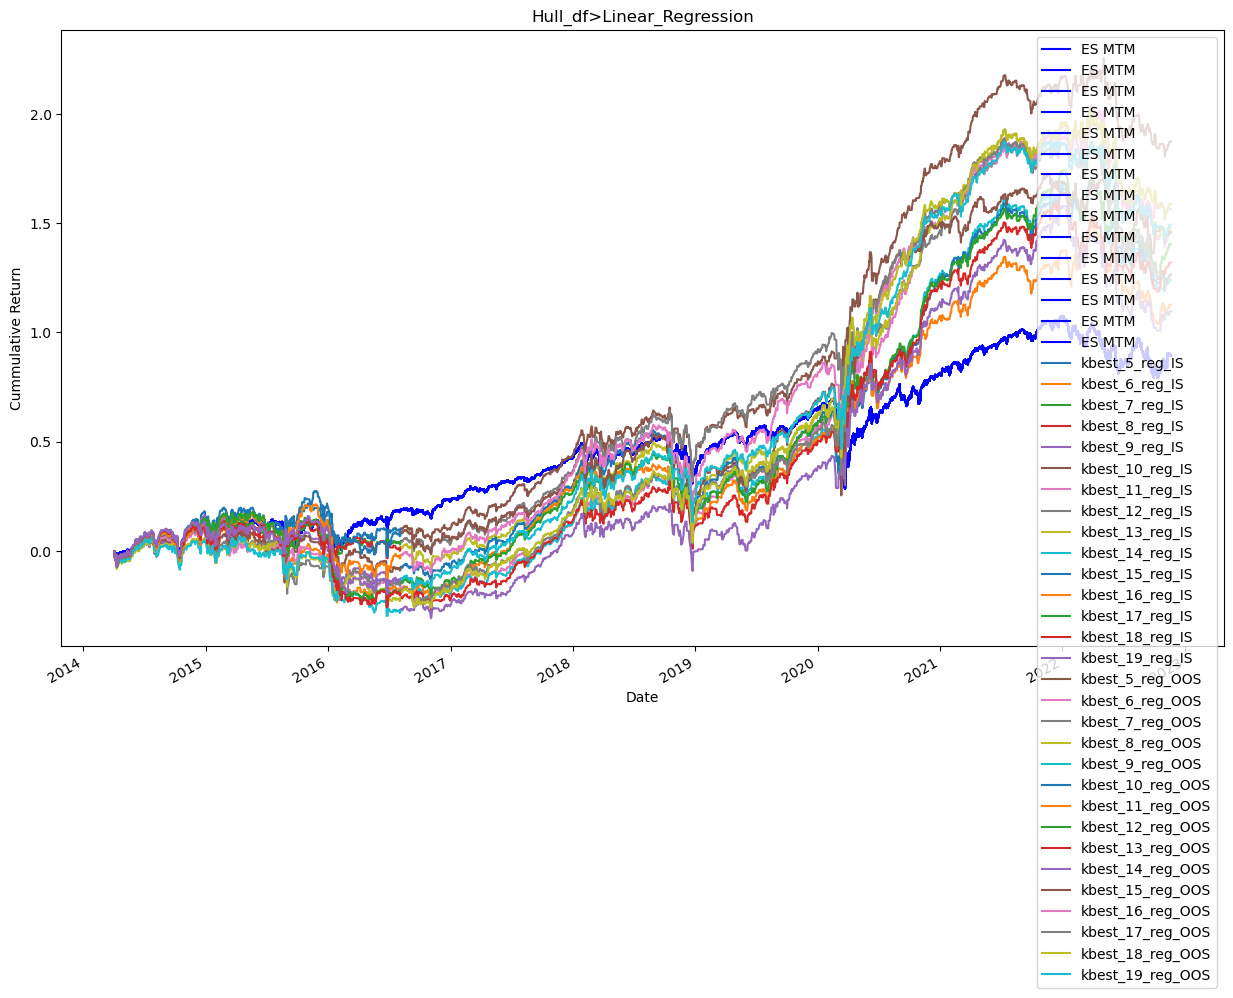

In [153]:
#IS_lab = [x+'_IS' for x in sweep_tags]
#OOS_lab = [x+'_OOS' for x in sweep_tags]

Results_xr['es_mtm'].plot.line(x='Date', label='ES MTM', color='blue')
Results_xr['perf_mtm'].sel(Date=cal['IS']).plot.line(x='Date', label=[x+'_IS' for x in sweep_tags])
Results_xr['perf_mtm'].sel(Date=cal['OOS']).plot.line(x='Date', label=[x+'_OOS' for x in sweep_tags])

plt.title('Hull_df>Linear_Regression')
plt.ylabel('Cummulative Return')
plt.legend()  # Ensure this line is present to display the legend
plt.show()

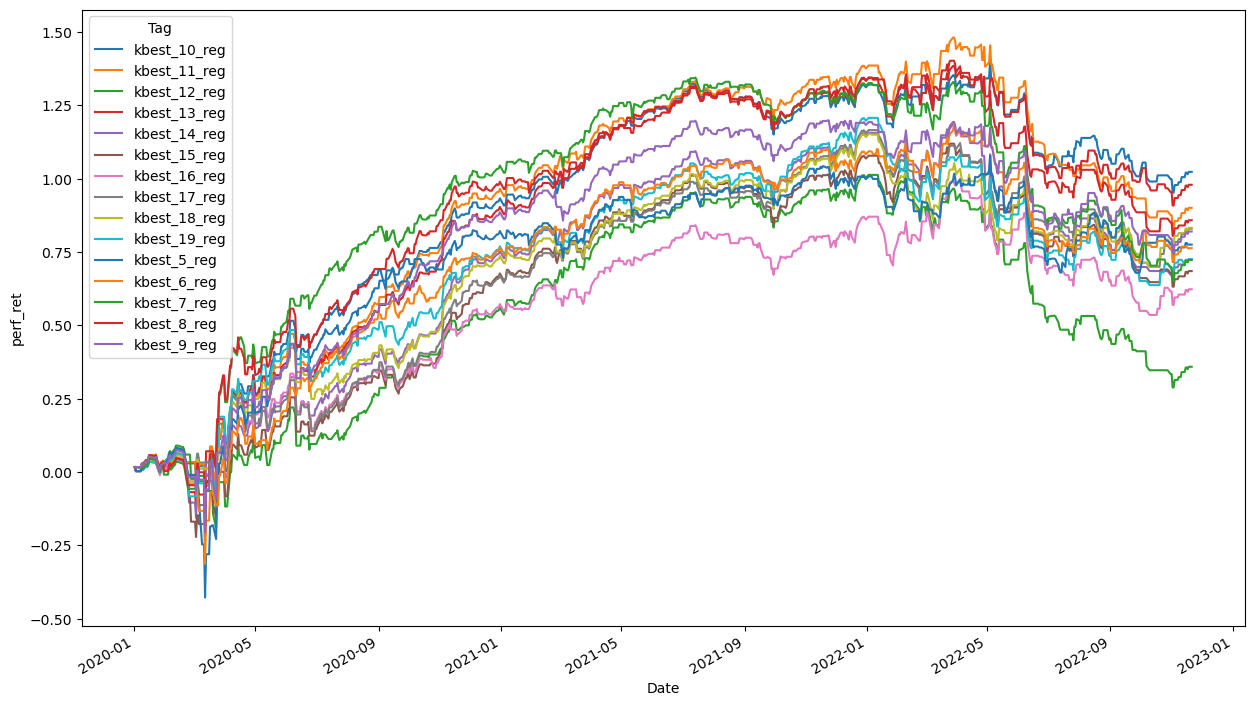

In [174]:
#Results_xr['predicted'].sel(Date=cal['OOS']).cumsum().plot.line(x='Date', label=[x+'_IS' for x in sweep_tags])
Results_xr['perf_ret'].sel(Date=slice("2020","2022")).cumsum(dim='Date').plot.line(x='Date', label=sweep_tags)

In [179]:
y

['SPY']

In [ ]:
# estimators = [
#     ("OLS", LinearRegression()),
#     ("Theil-Sen", TheilSenRegressor(random_state=42)),
#     ("RANSAC", RANSACRegressor(random_state=42)),
# ]

# ols =  LinearRegression(fit_intercept=True)
# ridge = Ridge(alpha=.9,fit_intercept=True)
# eln = ElasticNet(random_state=0,alpha=.5,l1_ratio=.5,fit_intercept=True,selection='random')

# learners = [ols, ridge, eln]
# learner_tags = sweep_tags = [str(x) for x in learners]


# for n, learner_tested in enumerate(learners):
#     pipe_steps=[('pca', PCA(n_components=2)), (learner_tags[n], learners[n])]
#     dims_dict = {}

#     regout_df = Simulate(X,y,window=cal['regression_est_window'],pipe_steps=pipe_steps,dims_dict=dims_dict)
#     Results_df = pd.concat([Results_df,sim_stats(regout_df,sweep_tags[n])],axis=1)
#     sim_xr = regout_df.to_xarray().expand_dims(Tag=[sweep_tags[n]])    
#     Results_xr = xr.merge([Results_xr,sim_xr])





In [203]:
df = pd.concat([X,y],axis=1)

correlations = df.corr()["SPY"].iloc[:-1]  # Exclude the target column from the result

# Create a DataFrame to report the correlations
correlation_report = pd.DataFrame({"Feature": correlations.index, "Pearson Correlation": correlations.values})
report = correlation_report.sort_values(by=['Pearson Correlation'])
for row in range(len(report.index)):
    print(row,report.loc[row,'Feature'],report.loc[row,'Pearson Correlation'])



0 US10YR -0.08762273442414403
1 TRAIL_12M_EPS_BEF_XO_ITEM -0.03235656072559073
2 PE_RATIO -0.08491346590804096
3 PX_OPEN -0.023623085800607492
4 PX_HIGH -0.0708859138872161
5 PX_LOW -0.05672423107249653
6 PX_LAST -0.08896933527367666
7 SPGSCI -0.03856147219578394
8 BDIY -0.0019062401549186194
9 VIX 0.027159497159758426
10 MVOLE -0.03889623122284667
11 DXY -0.028009413705344505
12 CPI -0.025341548476115788
13 ASPY -0.08410711120964373
14 advDecl 0.0016605529463895666
15 FedFunds -0.019369890453074957
16 NYSEADV -0.05025137868754034
17 BAA -0.010391991089392729
18 BER -0.03998472767477874
19 vintageCPI -0.024856703424964925
20 DividendToPriceRatio 0.07289618987497745
21 PxToBook -0.0899919431513219
22 AAA -0.056056726905516115
23 SI 0.013756129845798198
24 realVol 0.01398821487146487
25 VVIX -0.013297841138151214
26 NAPMNEWO 0.014015856032192915
27 NAPMPRIC 0.04268093976504334
28 NAPMPMI 0.005712708681307647
29 delinquency -0.0236764046933832
30 Consumption_new -0.024337285590530524
31 A

In [ ]:

y_pred = Results_xr['predicted'].sel(Tag='ewm_3_reg_oos').to_dataframe().drop('Tag',axis=1)
y_test = Results_xr['actual'].sel(Tag='ewm_3_reg_oos').to_dataframe().drop('Tag',axis=1)
df = pd.concat([y_pred,y_test],axis=1)
df['pos_bets'] = df['actual'].loc[df['predicted'] > 0]
#df.loc[(df['predicted'] > 0).index,df['actual']]
df['neg_bets'] = df['actual'].loc[df['predicted'] < 0]
df.describe()

In [206]:
report.sort_values(by=['Pearson Correlation'])

,Feature,Pearson Correlation
21,PxToBook,-0.089992
6,PX_LAST,-0.088969
0,US10YR,-0.087623
47,CATY,-0.086851
46,CAPE,-0.086826
...,...,...
58,RVX,0.039760
27,NAPMPRIC,0.042681
33,IAP,0.044837
20,DividendToPriceRatio,0.072896


In [207]:
df

,US10YR,TRAIL_12M_EPS_BEF_XO_ITEM,PE_RATIO,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,SPGSCI,BDIY,VIX,...,SPVXSP,VXD,VXN,RVX,VIX3M,VIX6M,VIX9D,VIX1Y,ETS,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2012-08-28,-0.670608,0.069054,-0.111762,0.479477,0.121448,0.617703,-0.100066,-0.424277,0.141007,1.152870,...,0.340518,1.132232,0.613818,0.402791,0.808625,0.676761,1.304651,0.690524,-0.003139,-0.000990
2012-08-29,-0.300859,-0.054675,-0.102531,-0.101329,-0.247784,-0.286887,-0.118305,0.179950,0.590046,0.167495,...,0.293059,0.588077,0.460541,0.120939,-0.069015,0.106738,0.241984,-0.437892,-0.069064,0.000777
2012-08-30,0.380118,-0.095849,0.040756,-0.118986,-0.036910,0.004734,0.020525,0.026717,-0.246025,0.547351,...,0.352813,0.361457,0.465864,0.400718,0.739545,0.592919,0.084328,0.486258,0.060686,-0.007233
2012-08-31,-0.509767,-0.133535,-0.649420,-0.004954,-0.337879,-0.665068,-0.701350,-0.204353,-0.571010,0.694191,...,0.496267,0.679031,0.839700,1.355299,0.525371,0.489120,1.000709,0.337179,-0.409901,0.004757
2012-09-04,-1.517614,-0.298362,0.425213,-0.651699,0.162666,0.071898,0.372500,0.951174,-0.104741,-0.269424,...,-0.671818,-0.713941,-0.557877,-0.767573,-0.279438,-0.259581,-0.665556,0.529458,0.273234,-0.000921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-15,0.243274,-0.378732,-0.504770,0.303867,0.204634,0.267631,-0.549160,-0.729264,-0.519989,0.655938,...,-0.009358,0.096045,0.579821,0.505222,0.272636,0.389698,-0.064806,0.468086,-0.948734,0.008493
2022-11-16,-0.866379,-0.431033,0.681966,0.558943,0.455990,-0.011467,0.614872,0.436589,-0.430265,0.412541,...,0.301901,0.155125,0.134725,0.139673,0.318536,0.344027,0.213719,-0.023140,0.062742,-0.007658
2022-11-17,-0.838032,-0.778156,-0.369780,-0.487955,-0.881633,0.072238,-0.502122,-0.408856,-0.175011,-0.247785,...,-0.537503,-0.351860,-0.163418,-0.120127,-0.427841,-0.470344,-0.857676,-0.342568,-0.024224,-0.003065
